### Import TensorFlow

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [3]:
import numpy as np

file = open('data/train_path_X_10000.data', 'rb')
train_X = np.load(file)
file.close()

file = open('data/train_Y_10000.data', 'rb')
train_Y = np.load(file)
file.close()

file = open('data/test_path_X_2000.data', 'rb')
test_X = np.load(file)
file.close()

file = open('data/test_Y_2000.data', 'rb')
test_Y = np.load(file)
file.close()

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


In [4]:
train_X.shape

(10000, 142, 36)

In [5]:
train_Y.shape

(10000,)

In [6]:
test_X.shape

(2000, 136, 36)

In [7]:
test_Y.shape

(2000,)

In [62]:
length_pad = 150
l_data = 36
assert train_X.shape[1] <= length_pad
assert test_X.shape[1] <= length_pad

In [9]:
train_X = np.pad(train_X, ((0,0), (0, length_pad - train_X.shape[1]), (0, 0)))
test_X = np.pad(test_X, ((0,0), (0, length_pad - test_X.shape[1]), (0, 0)))

print(train_X.shape)
print(test_X.shape)

(10000, 150, 36)
(2000, 150, 36)


### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [87]:
model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
#     tf.keras.layers.Reshape((length_pad * l_data,)),
    # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=1)
])
model.build(input_shape = (None, length_pad, l_data))

Here's the complete architecture of your model:

In [88]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 32)                8832      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 8,865
Trainable params: 8,865
Non-trainable params: 0
_________________________________________________________________


In [89]:
train_X[0:5].shape

(5, 150, 36)

In [90]:
test_output = model(train_X[0:5])
test_output.shape

TensorShape([5, 1])

### Compile and train the model

In [91]:
from tensorflow.keras.metrics import mean_squared_error

class LSTM_MSE(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        print (y_pred.shape)
        final_pred = tf.slice(y_pred, [0, y_pred.shape[1] - 1, 0], [y_pred.shape[0], 1, 1])
        mse = mean_squared_error(y_true, final_pred)
        return tf.reduce_mean(mse)

In [92]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mean_squared_error'])

history = model.fit(train_X, train_Y, epochs=30,
              validation_data=(test_X, test_Y))

Epoch 1/30
313/313 [==============================] - 4s 8ms/step - loss: 7196.0657 - mean_squared_error: 7196.0657 - val_loss: 5363.7041 - val_mean_squared_error: 5363.7041
Epoch 2/30
313/313 [==============================] - 2s 6ms/step - loss: 5126.5510 - mean_squared_error: 5126.5510 - val_loss: 4080.2776 - val_mean_squared_error: 4080.2776
Epoch 3/30
313/313 [==============================] - 2s 6ms/step - loss: 3915.8198 - mean_squared_error: 3915.8198 - val_loss: 3088.2463 - val_mean_squared_error: 3088.2463
Epoch 4/30
313/313 [==============================] - 2s 6ms/step - loss: 2971.9225 - mean_squared_error: 2971.9225 - val_loss: 2321.3105 - val_mean_squared_error: 2321.3105
Epoch 5/30
313/313 [==============================] - 2s 6ms/step - loss: 2261.1563 - mean_squared_error: 2261.1563 - val_loss: 1739.3192 - val_mean_squared_error: 1739.3192
Epoch 6/30
313/313 [==============================] - 2s 6ms/step - loss: 1699.3809 - mean_squared_error: 1699.3809 - val_loss: 13

### Evaluate the model

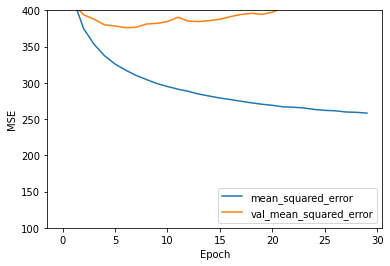

63/63 - 0s - loss: 411.6484 - mean_squared_error: 411.6484


In [86]:
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label = 'val_mean_squared_error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim([100, 400])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_X,  test_Y, verbose=2)

In [77]:
import math
print(math.sqrt(test_acc))

19.401963502288645


Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.

In [17]:
iteration = 1
model.save(f'models/scorer_{iteration}.model')

INFO:tensorflow:Assets written to: models/scorer_1.model\assets
